<a href="https://colab.research.google.com/github/bagasdal/bagasdal/blob/main/Temp_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Temp Time series


bagas daliyanto

In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

df = pd.read_csv('IOT-temp.csv')
df.head()

,id,room_id/id,noted_date,temp,out/in
0,__export__.temp_log_196134_bd201015,Room Admin,08-12-2018 09:30,29,In
1,__export__.temp_log_196131_7bca51bc,Room Admin,08-12-2018 09:30,29,In
2,__export__.temp_log_196127_522915e3,Room Admin,08-12-2018 09:29,41,Out
3,__export__.temp_log_196128_be0919cf,Room Admin,08-12-2018 09:29,41,Out
4,__export__.temp_log_196126_d30b72fb,Room Admin,08-12-2018 09:29,31,In


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97606 entries, 0 to 97605
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          97606 non-null  object
 1   room_id/id  97606 non-null  object
 2   noted_date  97606 non-null  object
 3   temp        97606 non-null  int64 
 4   out/in      97606 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.7+ MB


In [ ]:
df.isnull().sum()

id            0
room_id/id    0
noted_date    0
temp          0
out/in        0
dtype: int64

In [ ]:
# Filtering Data

index_names = df[ df['out/in'] == 'In' ].index
df.drop(index_names, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77261 entries, 2 to 97599
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          77261 non-null  object
 1   room_id/id  77261 non-null  object
 2   noted_date  77261 non-null  object
 3   temp        77261 non-null  int64 
 4   out/in      77261 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.5+ MB


In [ ]:
# Drop sebagian data untuk waktu komputasi yang lebih cepat
n = 3000
  
# Dropping last n rows using drop
df.drop(df.tail(n).index, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 2 to 25439
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          20000 non-null  object
 1   room_id/id  20000 non-null  object
 2   noted_date  20000 non-null  object
 3   temp        20000 non-null  int64 
 4   out/in      20000 non-null  object
dtypes: int64(1), object(4)
memory usage: 937.5+ KB


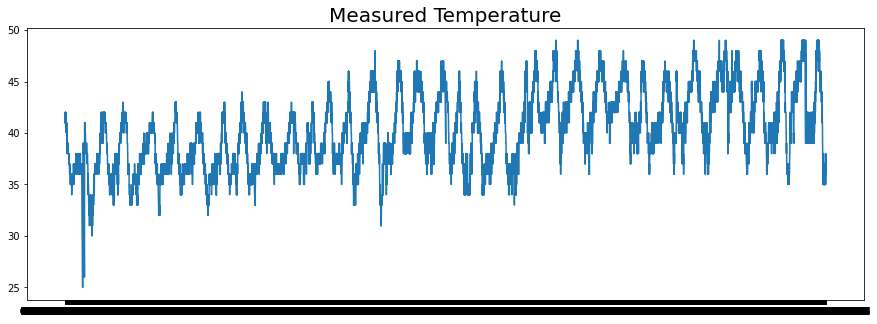

In [ ]:
dates = df['noted_date'].values
temp  = df['temp'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Measured Temperature',
          fontsize=20);

In [ ]:
print(temp.dtype)

int64


In [ ]:
temp = temp.astype('float32')
print(temp.dtype)

float32


In [ ]:
dates

array(['08-12-2018 09:29', '08-12-2018 09:29', '08-12-2018 09:25', ...,
       '18-10-2018 03:06', '18-10-2018 03:06', '18-10-2018 03:06'],
      dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split

temp_train, temp_valid, date_train, date_valid = train_test_split(temp, dates, test_size=0.2, random_state=0)

In [ ]:
print('Train set shape', temp_train.shape)
print('Validation set shape', temp_valid.shape)
temp_train

Train set shape (16000,)
Validation set shape (4000,)


array([40., 42., 35., ..., 41., 38., 38.], dtype=float32)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(temp_train, window_size=60, batch_size=100, shuffle_buffer=1000)
valid_set = windowed_dataset(temp_valid, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  # tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation="relu"),
  # tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
train_set

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>

In [ ]:
from tensorflow import keras

optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

# Callback
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='mae', patience=4)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
history = model.fit(train_set, 
                    validation_data=(valid_set),
                    epochs=50, verbose=1,
                    callbacks = [early_stopping_cb]
                    )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
160/160 [==============================] - 25s 132ms/step - loss: 34.4905 - mae: 34.9905 - val_loss: 24.3204 - val_mae: 24.8204
Epoch 2/50
160/160 [==============================] - 21s 131ms/step - loss: 5.5732 - mae: 6.0417 - val_loss: 2.2565 - val_mae: 2.7174
Epoch 3/50
160/160 [==============================] - 21s 131ms/step - loss: 2.2348 - mae: 2.6862 - val_loss: 2.2571 - val_mae: 2.7195
Epoch 4/50
160/160 [==============================] - 21s 132ms/step - loss: 2.2344 - mae: 2.6864 - val_loss: 2.2547 - val_mae: 2.7005
Epoch 5/50
160/160 [==============================] - 20s 126ms/step - loss: 2.2341 - mae: 2.6866 - val_loss: 2.2553 - val_mae: 2.7116
Epoch 6/50
160/160 [==============================] - 21s 129ms/step - loss: 2.2325 - mae: 2.6834 - val_loss: 2.2550 - val_mae: 2.7092
Epoch 7/50
160/160 [==============================] - 21s 128ms/step - loss: 2.2340 - mae: 2.6842 - val_loss: 2.2553 - val_mae: 2.7115
Epoch 8/50
160/160 [==============================]

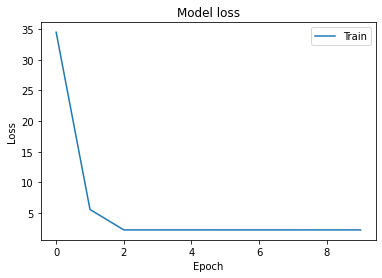

In [ ]:
import matplotlib.pyplot as plt

# Plotting Model Loss dan Accuracy

plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

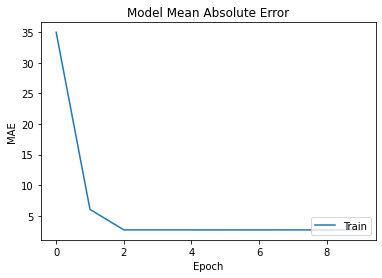

In [ ]:
plt.plot(history.history['mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()